# Workflow for parameter conversion
$$\require{mhchem}$$

Author: 

Joel W. Ager (jwager@lbl.gov, [ORCID](https://orcid.org/0000-0001-9334-9751)) [Group website](http://ager.mse.berkeley.edu), [GitHub](https://github.com/joelager)

Jinghan Li (mseljh@sjtu.edu.cn, [ORCID](https://orcid.org/0000-0003-3619-5121))

In [1]:
import numpy as np
from units import *
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

Zacros has a pre exponential
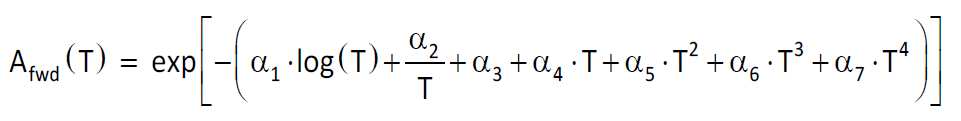

And an Arrhenius term for the rate constants
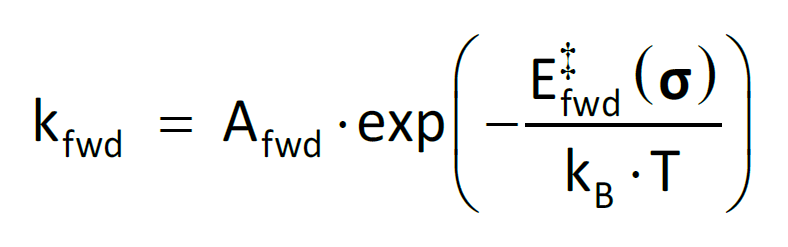

It was necessary to figure out what values of $\alpha_i$ would allow Bulter-Volmer-type rates to be simulated. Also, while temperature will always be positive, voltages can be negative or positive. Zacros gives an error if the temperature is negative so an offset had to be employed.

The Bulter-Volmer form is:

$$k_{EC} = k_0 \exp\left( \frac{\alpha q E_{app}}{k_B T} \right) $$

where I am going to let transfer coeffient $\alpha$ also carry information about whether it is a reduction or oxidation reaction.  By inspection for Zacros:

$$E^{\ddagger} = 0$$
$$\alpha_1 = \alpha_2 = \alpha_5 = \alpha_6 = \alpha_7 = 0   $$

So now the Zacro rate constant is:

$$ k_{Zacros}  = \exp(-\alpha_3) \, \exp(-\alpha_4 T')$$

where $T'$ will actually be $E_{\textrm{app}} + T_{\textrm{offset}}$

$T_{\textrm{offset}}$ was chosen to ensure that Zacros does not get a negative temperature when negative potential is applied, defaults to 10 kelvin.

## 01 When the rate constant is provided as a constant number that does not change as potential changes.
> Here, we use constants for CO stripping as an example. The parameters for the three elementary steps were given as constant.  
This is just to demonstrate how a constant can be described by Zacros expression. Actually, in Zacros either a constant reaction rate or an expression can be used. Only for the reversible step, the form for forward rate and the ratio between forward and backward should be in the same form, either in constant or in expression form.

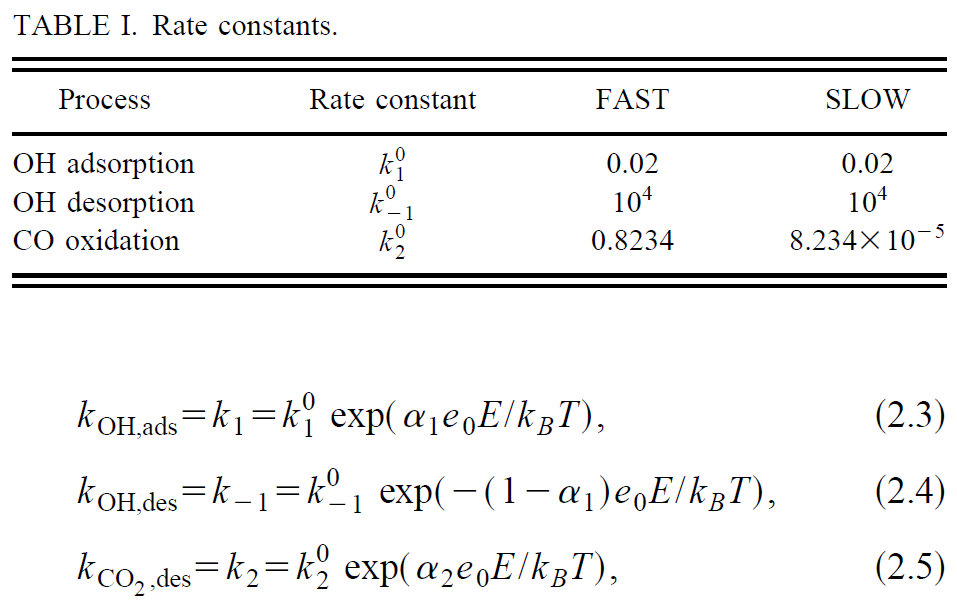

## For simplification
We set
$$ f= \frac{\alpha q }{k_B T}$$

for forward reaction $\alpha = 0.5$, for backward reaction $\alpha = -0.5$

$$k_{EC} = k_0 \exp\left( \frac{\alpha q E_{app}}{k_B T} \right) \rightarrow  ln k_{EC} = ln k_0 + f E_{app} $$
$$ k_{Zacros}  = \exp(-\alpha_3) \, \exp(-\alpha_4 T') \rightarrow  ln k_{Zacros} = -\alpha_3-\alpha_4 T' = -\alpha_3-\alpha_4 T_{offset}-\alpha_4 E_{app} $$<br/>
<center>Set $k_{Zacros}=k_{EC}$, we get = $-\alpha_4 = f$ and $-\alpha_3-\alpha_4 T_{offset} = ln k_0$</center><br/>

$$ \left\{
\begin{aligned}
\alpha_3= f T_{offset}-lnk_0 \\
\alpha_4 = -f
\end{aligned}
\right.
$$

In [2]:
# constant 
T_offset = 10
alpha = 0.5
T = 300*kelvin
f = (alpha * q)/(kB * T)
def convertZacros(k_0, sign):
    """
    Make a function to convert electrochemical rate constants in Bulter-Volmer form
    k0 = pre-exponential
    E0 = equilibrum potential (The simplified part considered this as 0)
    α = transfer coeffient, we will also use this to specify oxidation or reduction
    T_offset = value chosen to ensure that Zacros does not get a negative temperature
    
    Returns
    α3 and α4 to use in Zacros input files
    To do a potential step, add the desired potential to the T_offset
        e.g. 10.5 for +0.5 V or 9.5 for -0.5 V"""
    
    α_3 = f*sign*T_offset-np.log(k_0)
    α_4 = -f*sign
    
    return [α_3, α_4]

In [3]:
# Rate constant conversion
print ('Parameters for CO stripping converted to Zacros parameters:α3 and α4')
k1 = 0.02
α1 = 1
print('for k1 = {} α3 = {}\t α4 = {}'.format(k1,convertZacros(k1, α1)[0],convertZacros(k1, α1)[1]))

k_1 = 1e4
α_1 = -1
print('for k-1 = {} α3 = {}\t α4 = {}'.format(k_1,convertZacros(k_1, α_1)[0],convertZacros(k_1, α_1)[1]))

k2_f = 0.8234  # fast in mechanism
k2_s = 8.234e-5  # slow in mechanism
α2 = 1
print('for k2 = {} in Fast mechanism, α3 = {}\t α4 = {}'.format(k2_f,convertZacros(k2_f, α2)[0],convertZacros(k2_f, α2)[1]))
print('for k2 = {} in Slow mechanism, α3 = {}\t α4 = {}'.format(k2_s,convertZacros(k2_s, α2)[0],convertZacros(k2_s, α2)[1]))

Parameters for CO stripping converted to Zacros parameters:α3 and α4
for k1 = 0.02 α3 = 197.32072222966056	 α4 = -19.34086992242324
for k-1 = 10000.0 α3 = -202.61903959620858	 α4 = 19.34086992242324
for k2 = 0.8234 in Fast mechanism, α3 = 193.60301239387874	 α4 = -19.34086992242324
for k2 = 8.234e-05 in Slow mechanism, α3 = 202.81335276585492	 α4 = -19.34086992242324


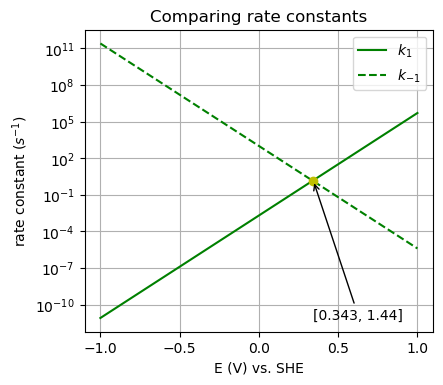

In [4]:
# To find at which potential the reaction reaches equilibrium.
# Here, take the OH adsorption and desorption as the example.

plt.figure(figsize=(4.5,4), dpi=100)
plt.title('Comparing rate constants')

def k (x, a3, a4):
    return np.exp(-a3-a4*(10+x))

x = np.linspace(-1, 1, 100)

x1 = np.array(x)
y1 = k(x, 199.6233073226546, -19.34086992242324)
y2 = k(x, -200.31645450321454, 19.34086992242324)  # Parameters copied from previous calculations. (α3 and α4)

# Find the interaction.
x_start = np.min(x1)
x_end = np.max(x1)+1

x_line = x1.copy()


y=y1-y2
nLen=len(x1)
xzero=np.zeros((nLen-1,))
yzero=np.zeros((nLen-1,))
for i in range(nLen-1):
    if np.dot(y[i], y[i+1]) == 0:#   %==0
        if y[i]==0:
            xzero[i]=i
        if y[i+1] == 0:
            xzero[i+1]=i+1
    elif np.dot(y[i],y[i+1]) < 0:# Have intersections.
        yzero[i] = np.dot(abs(y[i]) * y2[i+1] + abs(y[i+1])*y2[i], 1/(abs(y[i+1])+abs(y[i])))
        xzero[i] = np.dot(abs(x1[i]) * x1[i+1] + abs(x1[i+1])*x1[i], 1/(abs(x1[i+1])+abs(x1[i])))
        inx = xzero[i]
        iny = yzero[i]
    else:
        yzero[i]=xzero[i]=None            

plt.semilogy(x1, y1, 'g', label='$k_{1}$')
plt.semilogy(x1, y2, 'g--', label='$k_{-1}$')
plt.semilogy(xzero,yzero,'yo')

plt.legend(loc='best')
plt.xlabel("E (V) vs. SHE")
plt.ylabel("rate constant ($s^{-1}$)")

plt.annotate(r'[{:.3}, {:.3}]'.format(inx,iny),xy = (inx,iny),xycoords = 'data',xytext= (0,-100),textcoords = 'offset points'
             ,fontsize = 10,arrowprops = dict(arrowstyle = '->',connectionstyle = None))

plt.grid()
plt.savefig('OH equilibrium')   
plt.show()

## 02 Rate constant conversion for equilibrium reaction
The Zacro rate constant is:

$$ k_{Zacros}  = \exp(-\alpha_3) \, \exp(-\alpha_4 T')$$

where $T'$ will actually be $E_{\textrm{app}} + T_{\textrm{offset}}$

This is to determine the parameter `α3f` and `α4f` for the `pre_expon` and `β3` and `β4` for `pe_ratio`, based on the equilibrium constant `K` and activity coefficent `a`.

Equilibrium constant can only give the ratio between forward and backward rate, but the absolute rate constant of either reaction need to be determined manually (`α3f` and `α4f` ).

>Goodpaster, J. D.; Bell, A. T.; Head-Gordon, M. Identification of Possible Pathways for C–C Bond Formation during Electrochemical Reduction of CO<sub>2</sub> : New Theoretical Insights from an Improved Electrochemical Model. [*J. Phys. Chem. Lett.* **2016**, 7, 1471–1477](http://pubs.acs.org/doi/10.1021/acs.jpclett.6b00358). 

Take this reaction from the Goodpaster model for example:
$$\ce{H2O{(aq)} -> \star H2O}$$

This reacation has a potential dependant K

At the specific potential `Eapp`, when equilibrium reached.
$$ \theta_{H_2O} = K_6 \theta_v a_{H_2O}$$
Here, `aH2O = 1`
$$ \theta_{H_2O} = K_6 (1- \theta_{H_2O}) a_{H_2O}$$
$$ K_6 = \frac{\theta_{H_2O}}{(1- \theta_{H_2O}) a_{H_2O}}$$
Taking kinetics into consideration, at equilibrium,
$$kb\theta_{H_2O} = kf(1- \theta_{H_2O})$$
$$ \frac{kf}{kb} = \frac{\theta_{H_2O}}{(1- \theta_{H_2O}) }$$
$$ K_6 = \frac{kf}{kb} \frac{1}{a_{H_2O}} = \frac{\theta_{H_2O}}{(1- \theta_{H_2O}) a_{H_2O}}$$

Use Zacros form to describe the rate constant, $T'$ will actually be $E_{\textrm{app}} + T_{\textrm{offset}}$
$$ kf  = \exp(-\alpha_{3f}) \, \exp(-\alpha_{4f} T')$$
$$ kb  = \exp(-\alpha_{3b}) \, \exp(-\alpha_{4b} T')$$
$$ K_6 = \frac{kf}{kb} \frac{1}{a_{H_2O}} = \frac{\exp(-\alpha_{3f}) \, \exp(-\alpha_{4f} T')}{\exp(-\alpha_{3b}) \, \exp(-\alpha_{4b} T') a_{H_2O}}$$
$$ ln(K_6) = -\alpha_{3f}-\alpha_{4f} T'+\alpha_{3b}+\alpha_{4b} T'- ln(a_{H_2O})= -(\alpha_{3f}-\alpha_{3b}+ln(a_{H_2O}))-(\alpha_{4f}-\alpha_{4b}) (E_{\textrm{app}} + T_{\textrm{offset}})$$ 
$$ ln(K_6) = -(\alpha_{3f}-\alpha_{3b}+ln(a_{H_2O}))-(\alpha_{4f}-\alpha_{4b}) T_{\textrm{offset}}-(\alpha_{4f}-\alpha_{4b}) E_{\textrm{app}} \tag{1}$$ 

$$ K_6 = \exp(\frac{-ΔG_6^0}{k_B T})$$
$$ ΔG_6^0 = (a E_{app} + b) eV$$
> Here, `a` = 0.0846, `b` = 0.0631
$$ ln(K_6) = \frac{-(a E_{app} + b) eV}{k_B T} = \frac{-a eV}{k_B T}E_{app} + \frac{-b eV}{k_B T}\tag{2}$$

By comparing equation `(1)` and `(2)`, we get
$$ \left\{
\begin{array}{1}
-(\alpha_{3f}-\alpha_{3b}+ln(a_{H_2O}))-(\alpha_{4f}-\alpha_{4b}) T_{\textrm{offset}} = \frac{-b eV}{k_B T} \\
-(\alpha_{4f}-\alpha_{4b}) = \frac{-a eV}{k_B T}
\end{array}
\right.
$$
We then have,

$$ \left\{
\begin{array}{1}
f = \alpha_{4f}-\alpha_{4b} = \frac{a eV}{k_B T} \\
d = \alpha_{3f}-\alpha_{3b} = -(\alpha_{4f}-\alpha_{4b}) T_{\textrm{offset}} + \frac{b eV}{k_B T} -ln(a_{H_2O})= -f T_{\textrm{offset}} + \frac{b eV}{k_B T}-ln(a_{H_2O})
\end{array}
\right.
$$

For $\alpha_f = -\alpha_b = -0.5$, $\alpha_{4f} = -\alpha_{4b}= \frac{1}{2}f$  
And by changing the absolute value of $\alpha_{3f}$ and $\alpha_{3b}$, the reaction rate will be changed.


In [5]:
# Take equation 1 as an example 

RN = 1  # change the reaction number here.

# change the parameters here 
#Reaction 1 CO adsorption
a = 0.1828
b = - 0.0797
ac = 0.015


# #Reaction 6 water adsorption, chemical step
# a = 0.0846
# b = 0.0631
# ac = 1

T_offset = 10
T = 300*kelvin

f = (a*eV)/(kB * T) #α_4f-α_4b
d = (b*eV)/(kB * T)-f*T_offset-np.log(ac) #α_3f-α_3b
α_4f = 1/2*f
α_4b = -α_4f
α_3f = 1/2*d # only a suggestion, need to be manually confirmed with supplementary information.
α_3b = -α_3f

print('α_3f = {}, α_4f = {}'.format(α_3f, α_4f))
print('α_3b = {}, α_4b = {}'.format(α_3b, α_4b))
print('β_3 = {}, β_4 = {}'.format(d, f))

α_3f = -9.504669515915603, α_4f = 0.9670435045712973
α_3b = 9.504669515915603, α_4b = -0.9670435045712973
β_3 = -19.009339031831207, β_4 = 1.9340870091425946


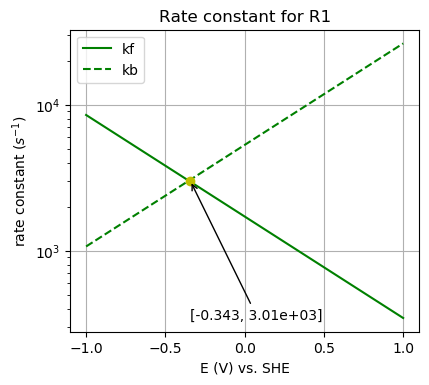

In [6]:
'''
Use the following part to manipulate the absolute reaction rate.
The intersection gives the value of the potential when surface coverage θ = 0.5, and the rate constant k1 at that point.
'''
plt.figure(figsize=(4.5,4), dpi=100)
plt.title('Rate constant for R{}'.format(RN))

def k (x, a3, a4):
    return np.exp(-a3-a4*(T_offset+x))

x = np.linspace(-1, 1, 100) # here to set the potential range 

x1 = np.array(x)

y1 = k(x, α_3f, α_4f)
y2 = k(x, α_3b, α_4b)

# type in rate constant to manipulate the rate of reactions.
y1 = k(x, -23.46, 1.6014240435700682)
y2 = k(x, 7.44, -1.6014240435700682)

x_start = np.min(x1)
x_end = np.max(x1)+1

x_line = x1.copy()


y=y1-y2
nLen=len(x1)
xzero=np.zeros((nLen-1,))
yzero=np.zeros((nLen-1,))
for i in range(nLen-1):
    if np.dot(y[i], y[i+1]) == 0:#   %==0
        if y[i]==0:
            xzero[i]=i
        if y[i+1] == 0:
            xzero[i+1]=i+1
    elif np.dot(y[i],y[i+1]) < 0:# Have intersections.
        yzero[i] = np.dot(abs(y[i]) * y2[i+1] + abs(y[i+1])*y2[i], 1/(abs(y[i+1])+abs(y[i])))
        xzero[i] = np.dot(abs(x1[i]) * x1[i+1] + abs(x1[i+1])*x1[i], 1/(abs(x1[i+1])+abs(x1[i])))
        inx = xzero[i]
        iny = yzero[i]
    else:
        yzero[i]=xzero[i]=None            

plt.semilogy(x1, y1, 'g', label='kf')
plt.semilogy(x1, y2, 'g--', label='kb')
plt.semilogy(xzero,yzero,'yo')

plt.legend(loc='best')
plt.xlabel("E (V) vs. SHE")
plt.ylabel("rate constant ($s^{-1}$)")

plt.annotate(r'[{:.3}, {:.3}]'.format(inx,iny),xy = (inx,iny),xycoords = 'data',xytext= (0,-100),textcoords = 'offset points'
             ,fontsize = 10,arrowprops = dict(arrowstyle = '->',connectionstyle = None))

plt.grid()
plt.savefig('R{}'.format(RN))   
plt.show()

## Test whether the parameter conversion is right
$$ K_6 = \exp(\frac{-ΔG_6^0}{k_B T})$$
$$ ΔG_6^0 = (a E_{app} + b) eV$$
$$ K_6 = \frac{\theta_{H_2O}}{(1- \theta_{H_2O}) a_{H_2O}}$$
Given `θ`, we can get the `K` value the related potential `E`.

In [7]:
def K(θ, ac):
    return θ/(ac*(1-θ))
def ΔG(K):
    return -np.log(K)*(kB*T)
def E(ΔG, a, b):
    return (ΔG/eV-b)/a

print (K(0.5, 1))
print (E(ΔG(K(0.5, 1)),0.0846,0.0631))

1.0
-0.7458628841607566


In [8]:
# Calculate A based on α and E, take R6 as an example.
def k_Zacros(T_prime, α_3, α_4):
    """
    Calculates the EC rate constant using the form in the program for the prefactor
    """
    A = np.exp(-α_3 + -α_4*T_prime)
    return A

U = -0.747
T = 9.253
# k1
α_3f = -15.141967194577372
α_4f = 1.6362376097346347 
# k2
α_3b = 15.141967194577372
α_4b = -1.6362376097346347
# K
β_3 = -30.283934389154744
β_4 = 3.2724752194692694 
#K from E
K6 = np.exp((-(0.0846*U + 0.0631)*eV)/(kB*300*kelvin))

print ('pre_expon for k1: {}'.format (k_Zacros(T, α_3f, α_4f)))
print ('pre_expon for k-1: {}'.format (k_Zacros(T, α_3b, α_4b)))
print ('The following K should be similar')
print ('K from pe_ratio: {}'.format (k_Zacros(T, β_3, β_4)))
print ('K calculated from pre_expon of fwd and rev reactions: {}'.format (k_Zacros(T, α_3f, α_4f)/k_Zacros(T, α_3b, α_4b)))
print ('K from the equation: {}'.format (K6))

pre_expon for k1: 1.0018623236775392
pre_expon for k-1: 0.998141138124944
The following K should be similar
K from pe_ratio: 1.0037281156045583
K calculated from pre_expon of fwd and rev reactions: 1.0037281156045583
K from the equation: 1.0037281156045532


## 03 Rate constant conversion for reactions with potential dependent rate constant.
The Zacro rate constant is:

$$ k_{Zacros}  = \exp(-\alpha_3) \, \exp(-\alpha_4 T')$$

where $T'$ will actually be $E_{\textrm{app}} + T_{\textrm{offset}}$

This is to determine the parameter `α3f` and `α4f` for forward reaction and `α3b` and `α4b` for backward reaction based on potential dependent `ΔG`.  
If a reversible step form is needed. `α3f` and `α4f` for the `pre_expon` and `β3` and `β4` for `pe_ratio`.

Use Zacros form to describe the rate constant, $T'$ will actually be $E_{\textrm{app}} + T_{\textrm{offset}}$
$$ kf  = \exp(-\alpha_{3f}) \, \exp(-\alpha_{4f} T')$$
$$ kb  = \exp(-\alpha_{3b}) \, \exp(-\alpha_{4b} T')$$
Take one k for example,
$$ ln(k) = -\alpha_{3}-\alpha_{4} T'= -\alpha_{3}-\alpha_{4} (E_{\textrm{app}} + T_{\textrm{offset}}) = -\alpha_{3}-\alpha_{4} T_{\textrm{offset}} -\alpha_{4}E_{\textrm{app}} \tag{1}$$

And,
$$ k = \frac{k_B T}{h}\exp(\frac{-ΔG}{k_B T})$$
$$ ΔG = (a E_{app} + b) eV$$
$$ ln(k) = ln(\frac{k_B T}{h})+\frac{-(a E_{app} + b) eV}{k_B T} = ln(\frac{k_B T}{h}) + \frac{-b eV}{k_B T}+\frac{-a eV}{k_B T}E_{app}\tag{2}$$

By comparing equation `(1)` and `(2)`, we get
$$ \left\{
\begin{array}{1}
\alpha_{3}+\alpha_{4} T_{\textrm{offset}} = \frac{b eV}{k_B T}-ln(\frac{k_B T}{h}) \\
\alpha_{4} = \frac{a eV}{k_B T}
\end{array}
\right.
$$
We then have,
$$\alpha_{3} = \frac{b eV}{k_B T}-ln(\frac{k_B T}{h})-\alpha_{4} T_{\textrm{offset}}$$

In [9]:
# Take equation 2 as an example 
# def k2(U): 
#     return ((kB*300*kelvin)/h) * np.exp(-ΔG2dagger(U)/(kB*300*kelvin))
# def kminus2(U): 
#     return ((kB*300*kelvin)/h) * np.exp(-ΔGminus2dagger(U)/(kB*300*kelvin))

# def ΔG2dagger(U):
#     return (-0.1723*U + 0.4616)*eV
# def ΔGminus2dagger(U):
#     return (-0.3891*U - 0.0620)*eV

RN = 3  # change the name here 

# change the parameters here 
# # Reaction 2 *CO dimerization, forward and reverse
# af = -0.1723
# bf = 0.4616
# ab = -0.3891
# bb = - 0.0620

# Reaction 3 *CO protonation, forward and reverse
af = 0.7808
bf = 1.6744
ab = -0.0565
bb = 0.0105

# # Reaction 4 protontation of CO dimer, just forward
# af = -0.1667
# bf = 0.4278

# # Reaction 5 *CO + *CHO, the other way to get to C2
# af = -0.0804
# bf = 0.6001

# # Reaction 7 water reduction to *H and OH-, forward and back
# af = 0.4188
# bf = 1.0402
# ab = -0.9979
# bb = - 0.3831

# # Reaction 8 HER with *H and H2O in solution
# af = 0.7988
# bf = 1.5334


T_offset = 10
T = 300*kelvin

α_4f = (af*eV)/(kB * T) 
α_3f = (bf*eV)/(kB * T)-np.log((kB * T)/h)-α_4f*T_offset
α_4b = (ab*eV)/(kB * T) 
α_3b = (bb*eV)/(kB * T)-np.log((kB * T)/h)-α_4b*T_offset
β_3 = α_3f-α_3b # If want to change into a reversible reaction.
β_4 = α_4f-α_4b

print('α_3f = {}, α_4f = {}'.format(α_3f, α_4f))
print('α_3b = {}, α_4b = {}'.format(α_3b, α_4b))
print('β_3 = {}, β_4 = {}'.format(β_3, β_4))

α_3f = -266.72208154848784, α_4f = 30.20270273477076
α_3b = -7.202418487716173, α_4b = -2.185518320331132
β_3 = -259.5196630607717, β_4 = 32.388221055101894


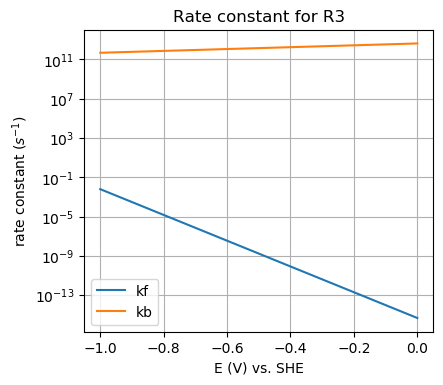

In [10]:
plt.figure(figsize=(4.5,4), dpi=100)
plt.title('Rate constant for R{}'.format(RN))

def k (x, a3, a4):
    return np.exp(-a3-a4*(T_offset+x))

x = np.linspace(-1, 0, 100) # here to set the potential range 

kf = k(x, α_3f, α_4f)
kb = k(x, α_3b, α_4b)

plt.semilogy(x, kf,  label='kf')
plt.semilogy(x, kb,  label='kb')

plt.legend(loc='best')
plt.xlabel("E (V) vs. SHE")
plt.ylabel("rate constant ($s^{-1}$)")

plt.grid()
plt.savefig('R{}'.format(RN))   
plt.show()

In [11]:
# for taking a into consideration (for reaction 7b and 3b, where OH- involved)
# a = 3.2e-5   # pH 7
a = 0.775    # pH 13

# Here to change the parameter.
# # R5
# α_3 = 24.849271427794903 

# R3b
α_3 = -7.202418487716173 
β_3 = -259.5196630607717

# # R7b
# α_3 = 341.72235065768103 
# β_3 = -492.94849236820966

α_3ph = α_3 - np.log(a)


# for OH in backward reaction, α_3 remain same.
β3ph = β_3 + np.log(a)

# # for OH in forward reaction, α_3a to be the new α_3.
# β3ph = β_3 - np.log(a)

print ('For a specific reaction, α3ph: {}'.format(α_3ph))
print ('For reversible reaction, β3ph: {}'.format (β3ph))

For a specific reaction, α3ph: -6.947526238087383
For reversible reaction, β3ph: -259.77455531040044
